In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from matplotlib import pyplot as plt

In [2]:
data_dir="./Cropdiseasedataset"

In [3]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=32, label_mode='categorical')

Found 20312 files belonging to 13 classes.


In [4]:
classes=data.class_names
classes

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
# Normalize the dataset
data=data.map(lambda x, y: (x / 255.0, y))

In [6]:
len(data)

635

In [7]:
train_size = 450
val_size = 65
test_size = 120

In [8]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [12]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       7

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [15]:
history = model.fit(train, validation_data=val,batch_size=32,epochs=10,callbacks=[early_stopping])

Epoch 1/10
450/450 [==============================] - 562s 1s/step - loss: 1.2084 - accuracy: 0.5983 - val_loss: 0.7492 - val_accuracy: 0.7370
Epoch 2/10
450/450 [==============================] - 568s 1s/step - loss: 0.6139 - accuracy: 0.7951 - val_loss: 0.5533 - val_accuracy: 0.8130
Epoch 3/10
450/450 [==============================] - 562s 1s/step - loss: 0.4062 - accuracy: 0.8611 - val_loss: 0.5498 - val_accuracy: 0.8173
Epoch 4/10
450/450 [==============================] - 578s 1s/step - loss: 0.2765 - accuracy: 0.9062 - val_loss: 0.3512 - val_accuracy: 0.8822
Epoch 5/10
450/450 [==============================] - 578s 1s/step - loss: 0.1863 - accuracy: 0.9352 - val_loss: 0.3906 - val_accuracy: 0.8793
Epoch 6/10
450/450 [==============================] - 564s 1s/step - loss: 0.1487 - accuracy: 0.9503 - val_loss: 0.3539 - val_accuracy: 0.8909
Epoch 7/10
450/450 [==============================] - 570s 1s/step - loss: 0.1089 - accuracy: 0.9636 - val_loss: 0.3389 - val_accuracy: 0.9024

In [16]:
# Save the model
model.save("model.h5")


C:\Users\shars\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy: {test_accuracy}")

120/120 [==============================] - 125s 840ms/step - loss: 0.4270 - accuracy: 0.8820
Test accuracy: 0.8820459246635437


In [18]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [19]:
pre=Precision()
rec=Recall()
acc=CategoricalAccuracy()

In [20]:
x_test=[]
y_test=[]
for batch in test.as_numpy_iterator():
    x,y=batch
    y=y.astype(int)
    x_test.append(x)
    y_test.append(y)

In [21]:
x_test=np.concatenate(x_test)
y_test=np.concatenate(y_test)

In [22]:
yhat=model.predict(x_test)

120/120 [==============================] - 96s 771ms/step


In [23]:
pre.update_state(y_test,yhat)
rec.update_state(y_test,yhat)
acc.update_state(y_test,yhat)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=3832.0>

In [24]:
pre.result().numpy(),rec.result().numpy(),acc.result().numpy()

(0.89098644, 0.8744781, 0.8812631)

In [25]:
y_test_labels=np.argmax(y_test,axis=1)
y=np.argmax(yhat,axis=1)

In [26]:
from sklearn.metrics import confusion_matrix as cm
import pandas as pd

In [27]:
matrix=cm(y_test_labels,y)
df=pd.DataFrame(matrix)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,178,10,0,0,1,1,0,7,0,0,0,0,0
1,5,148,1,1,2,10,1,4,1,0,0,0,0
2,0,12,23,0,0,0,0,0,1,0,0,0,0
3,0,10,0,355,2,2,0,3,1,1,10,0,0
4,2,5,0,16,99,24,4,4,3,11,11,1,2
5,1,26,0,0,20,291,6,12,1,0,2,0,3
6,1,2,0,0,3,4,171,7,2,0,1,1,1
7,8,8,2,6,8,4,22,243,5,12,3,5,2
8,0,0,0,0,3,1,2,0,285,24,4,2,0
9,0,5,0,4,11,0,1,0,7,229,1,0,21


In [28]:
from sklearn.metrics import classification_report
report = classification_report(y_test_labels, y)

In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       197
           1       0.65      0.86      0.74       173
           2       0.88      0.64      0.74        36
           3       0.92      0.92      0.92       384
           4       0.65      0.54      0.59       182
           5       0.86      0.80      0.83       362
           6       0.81      0.89      0.85       193
           7       0.86      0.74      0.79       328
           8       0.90      0.89      0.90       321
           9       0.83      0.82      0.82       279
          10       0.97      1.00      0.98      1032
          11       0.85      0.76      0.80        66
          12       0.91      1.00      0.95       279

    accuracy                           0.88      3832
   macro avg       0.85      0.83      0.83      3832
weighted avg       0.88      0.88      0.88      3832



In [30]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test_labels, y, average='weighted')
f1

0.8796449030121413

In [31]:
import seaborn as sns

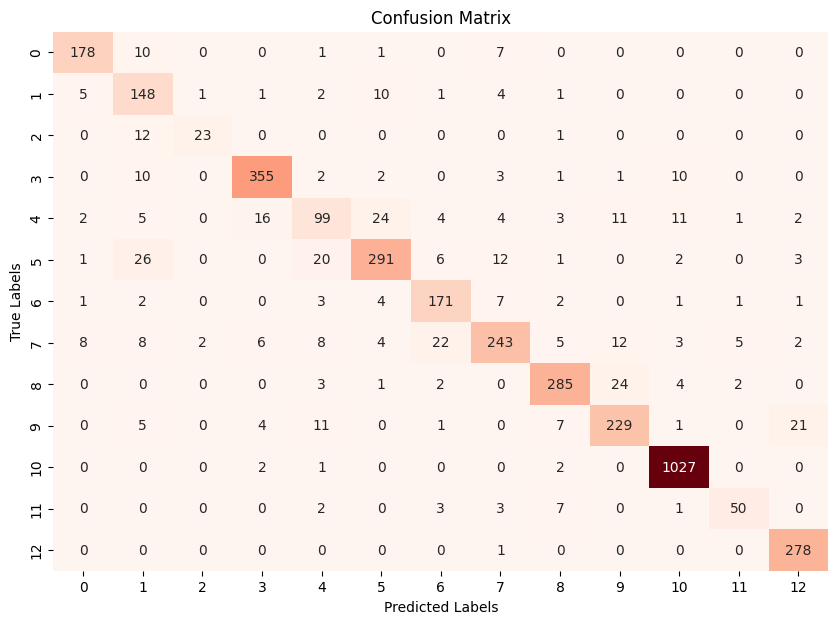

In [32]:
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()